In [3]:
import re
import pandas as pd
from pathlib import Path

# ---------- ユーザ設定 ---------------------------------
method_log_files = {
    'Fintune': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/fintune_er_reservoir0_cifar10_seed0_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/fintune_er_reservoir0_cifar10_seed1_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/fintune_er_reservoir0_cifar10_seed2_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/fintune_er_reservoir0_cifar10_seed3_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/fintune_er_reservoir0_cifar10_seed4_date2025_04_19/exp_log/experiment.log",
    ],
    # 
    'ER': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_cifar10_seed0_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_cifar10_seed1_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_cifar10_seed2_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_cifar10_seed3_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_cifar10_seed4_date2025_04_19/exp_log/experiment.log",
    ],
    'ER-Ring': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar10_seed0_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar10_seed1_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar10_seed2_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar10_seed3_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar10_seed4_date2025_04_19/exp_log/experiment.log",
    ],
    'FS-DGPM': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar10_seed0_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar10_seed1_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar10_seed2_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar10_seed3_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar10_seed4_date2025_04_19/exp_log/experiment.log",
    ],
    'GPM': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring0_cifar10_seed0_date2025_04_14/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring0_cifar10_seed1_date2025_04_14/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring0_cifar10_seed2_date2025_04_14/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring0_cifar10_seed3_date2025_04_14/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring0_cifar10_seed4_date2025_04_14/exp_log/experiment.log",
    ],
    'GPM-ER': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring2000_cifar10_seed0_date2025_04_14/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring2000_cifar10_seed1_date2025_04_14/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring2000_cifar10_seed2_date2025_04_14/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring2000_cifar10_seed3_date2025_04_14/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring2000_cifar10_seed4_date2025_04_14/exp_log/experiment.log",
    ],
    'Co2L': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar10_seed0_date2025_04_12/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar10_seed1_date2025_04_12/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar10_seed2_date2025_04_12/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar10_seed3_date2025_04_12/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar10_seed4_date2025_04_12/exp_log/experiment.log",
    ],
    'CCLIS': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar10_seed0_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar10_seed1_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar10_seed2_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar10_seed3_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar10_seed4_date2025_04_20/exp_log/experiment.log",
    ],
}
N_TASKS = 5           # task0 ～ task{N_TASKS-1}
# ------------------------------------------------------

# 正規表現
re_start = re.compile(r"Start Training current task (\d+)")       # タスク開始
re_epoch = re.compile(r"Epoch (\d+):")                            # エポック番号
re_acc   = re.compile(r"task(\d+)\s+acc=([0-9]+\.[0-9]+)")        # taskX acc=…

def parse_last_epoch_acc(fp: Path, n_tasks: int = N_TASKS) -> pd.DataFrame:
    """
    1 つの experiment.log から
      current_task (行) × task0 … task{n_tasks-1} (列)
    の DataFrame を返す。値は「各 current_task の最終エポック行の精度」。
    """
    current_task = None
    last_row     = {}            # タスクごとの最後の行を随時更新
    with fp.open(encoding="utf-8") as f:
        for line in f:
            m_start = re_start.search(line)
            if m_start:
                current_task = int(m_start.group(1))
                continue

            # エポック行かつ acc= を含む行のみ対象
            if current_task is None or " acc=" not in line or "Epoch" not in line:
                continue

            # 各タスク精度を抽出
            acc_dict = {f"task{m.group(1)}": float(m.group(2))
                        for m in re_acc.finditer(line)}
            # 列が欠けている場合は NaN
            for t in range(n_tasks):
                acc_dict.setdefault(f"task{t}", float('nan'))

            # 更新（後ろの行ほど新しい → 最後に残る）
            last_row[current_task] = acc_dict

    # DataFrame 化
    df = (pd.DataFrame.from_dict(last_row, orient="index")
            .sort_index()
            .rename_axis("current_task")
            .reset_index())
    return df

# ------------------ 集計と表示 -------------------------
pd.set_option("display.max_columns", None)

for method, files in method_log_files.items():
    per_seed_tables = []
    for seed_idx, fp in enumerate(files):
        fp = Path(fp)
        if not fp.exists():
            print(f"[warn] {fp} が見つかりません")
            continue
        df_seed = parse_last_epoch_acc(fp)
        df_seed.insert(0, "seed", seed_idx)
        per_seed_tables.append(df_seed)

    if not per_seed_tables:
        print(f"[info] {method}: ログなし")
        continue

    # ========= ① 全シード分を縦に結合してそのまま表示 =========
    big_df = pd.concat(per_seed_tables, ignore_index=True)
    print(f"\n=== {method}: 学習終了時 (seed 別) ===")
    # print(big_df.head())        # head → 全部見たい場合は .to_string()
    print(big_df.to_string())

    # ========= ② シード平均が欲しい場合はここを使用 =========
    mean_df = (big_df
                 .groupby("current_task")
                 .mean(numeric_only=True)
                 .reset_index())
    print(f"\n--- {method}: シード平均 ---")
    print(mean_df.to_string(index=False))

    # 必要なら CSV 保存
    # mean_df.to_csv(f"{method}_final_task_acc.csv", index=False)
    



=== Fintune: 学習終了時 (seed 別) ===
    seed  current_task  task0  task1  task2  task3  task4
0      0             0  98.45  46.65  51.85  49.85  49.60
1      0             1  65.95  90.40  46.25  49.00  54.15
2      0             2  69.15  66.55  94.15  52.30  49.75
3      0             3  59.80  52.25  67.25  98.05  48.90
4      0             4  29.80  46.50  48.20  64.80  97.90
5      1             0  97.85  53.40  44.55  48.85  48.10
6      1             1  72.25  91.50  30.60  58.45  59.90
7      1             2  73.45  69.65  93.65  50.40  37.30
8      1             3  58.40  56.55  58.30  97.85  62.15
9      1             4  30.40  46.10  45.85  67.70  95.25
10     2             0  98.35  53.40  54.45  61.15  69.40
11     2             1  70.30  92.05  54.20  43.65  52.30
12     2             2  71.95  67.20  95.15  45.95  49.15
13     2             3  56.60  54.20  64.75  98.15  56.20
14     2             4  25.60  47.20  47.70  65.00  97.50
15     3             0  98.00  48.00  4

In [4]:
import re
import pandas as pd
from pathlib import Path

# --------------------- ユーザ設定 --------------------------
method_log_files = {
    'Fintune': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/fintune_er_reservoir0_cifar10_seed0_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/fintune_er_reservoir0_cifar10_seed1_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/fintune_er_reservoir0_cifar10_seed2_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/fintune_er_reservoir0_cifar10_seed3_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/fintune_er_reservoir0_cifar10_seed4_date2025_04_19/exp_log/experiment.log",
    ],
    'ER': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_cifar10_seed0_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_cifar10_seed1_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_cifar10_seed2_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_cifar10_seed3_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_cifar10_seed4_date2025_04_19/exp_log/experiment.log",
    ],
    'ER-Ring': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar10_seed0_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar10_seed1_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar10_seed2_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar10_seed3_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar10_seed4_date2025_04_19/exp_log/experiment.log",
    ],
    'FS-DGPM': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar10_seed0_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar10_seed1_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar10_seed2_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar10_seed3_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar10_seed4_date2025_04_19/exp_log/experiment.log",
    ],
    # 'GPM': [
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring0_cifar10_seed0_date2025_04_14/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring0_cifar10_seed1_date2025_04_14/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring0_cifar10_seed2_date2025_04_14/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring0_cifar10_seed3_date2025_04_14/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring0_cifar10_seed4_date2025_04_14/exp_log/experiment.log",
    # ],
    # 'GPM-ER': [
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring2000_cifar10_seed0_date2025_04_14/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring2000_cifar10_seed1_date2025_04_14/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring2000_cifar10_seed2_date2025_04_14/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring2000_cifar10_seed3_date2025_04_14/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring2000_cifar10_seed4_date2025_04_14/exp_log/experiment.log",
    # ],
    # 'Co2L': [
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar10_seed0_date2025_04_12/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar10_seed1_date2025_04_12/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar10_seed2_date2025_04_12/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar10_seed3_date2025_04_12/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar10_seed4_date2025_04_12/exp_log/experiment.log",
    # ],
    'CCLIS': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar10_seed0_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar10_seed1_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar10_seed2_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar10_seed3_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar10_seed4_date2025_04_20/exp_log/experiment.log",
    ],
}
N_TASKS = 5          # task0 〜 task9
# ----------------------------------------------------------

re_start = re.compile(r"Start Training current task (\d+)")
re_acc   = re.compile(r"task(\d+)\s+acc=([0-9]+\.[0-9]+)")

def parse_last_epoch_acc(fp: Path, n_tasks=N_TASKS) -> pd.DataFrame:
    current_task = None
    last_row = {}
    with fp.open(encoding="utf-8") as f:
        for line in f:
            m_start = re_start.search(line)
            if m_start:
                current_task = int(m_start.group(1))
                continue
            if current_task is None or " acc=" not in line or "Epoch" not in line:
                continue

            accs = {f"task{m.group(1)}": float(m.group(2))
                    for m in re_acc.finditer(line)}
            for t in range(n_tasks):
                accs.setdefault(f"task{t}", float('nan'))
            last_row[current_task] = accs

    return (pd.DataFrame.from_dict(last_row, orient="index")
              .sort_index().rename_axis("current_task")
              .reset_index())

pd.set_option("display.max_columns", None)

for method, files in method_log_files.items():
    seed_tables = []
    for seed, path in enumerate(files):
        fp = Path(path)
        if not fp.exists():
            print(f"[warn] {fp} not found"); continue
        df_seed = parse_last_epoch_acc(fp)
        df_seed.insert(0, "seed", seed)
        seed_tables.append(df_seed)

    if not seed_tables:
        continue

    big_df = pd.concat(seed_tables, ignore_index=True)

    # ---- ① current_task == 9 の行を取り出し、タスク平均を計算 ------------
    task_cols = [f"task{i}" for i in range(N_TASKS)]
    ct9 = big_df[big_df["current_task"] == 4].copy()
    ct9["avg_all_tasks"] = ct9[task_cols].mean(axis=1)

    # ---- ② シードごとの平均精度 -----------------
    print(f"\n[{method}]  current_task 4 — seed 別平均精度")
    print(ct9[["seed", "avg_all_tasks"]].to_string(index=False))

    # ---- ③ シード間でさらに平均した 1 本の値 --------
    overall = ct9["avg_all_tasks"].mean()
    print(f"[{method}]  current_task 4 — 全シード平均: {overall:.2f}%")



[Fintune]  current_task 4 — seed 別平均精度
 seed  avg_all_tasks
    0          57.44
    1          57.06
    2          56.60
    3          55.62
    4          55.70
[Fintune]  current_task 4 — 全シード平均: 56.48%

[ER]  current_task 4 — seed 別平均精度
 seed  avg_all_tasks
    0          86.46
    1          87.52
    2          91.16
    3          85.07
    4          91.79
[ER]  current_task 4 — 全シード平均: 88.40%

[ER-Ring]  current_task 4 — seed 別平均精度
 seed  avg_all_tasks
    0          94.03
    1          93.79
    2          93.48
    3          93.73
    4          93.25
[ER-Ring]  current_task 4 — 全シード平均: 93.66%

[FS-DGPM]  current_task 4 — seed 別平均精度
 seed  avg_all_tasks
    0          83.35
    1          85.11
    2          84.70
    3          84.52
    4          85.66
[FS-DGPM]  current_task 4 — 全シード平均: 84.67%
[warn] /home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar10_seed4_date2025_04_20/exp_log/experiment.log not found

[CCLIS]  current_task 4 — seed

method:  Fintune
method:  Fintune
method:  Fintune
method:  Fintune
method:  Fintune
method:  ER
method:  ER
method:  ER
method:  ER
method:  ER
method:  ER-Ring
method:  ER-Ring
method:  ER-Ring
method:  ER-Ring
method:  ER-Ring
method:  FS-DGPM
method:  FS-DGPM
method:  FS-DGPM
method:  FS-DGPM
method:  FS-DGPM
method:  CCLIS
method:  CCLIS
method:  CCLIS
method:  CCLIS
⚠️  File not found: /home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar10_seed4_date2025_04_20/exp_log/experiment.log

=====  BWT (Backward Transfer)  =====
  Method  Seed  Tasks  BWT (%)  Mean BWT (%)
 Fintune     0      5  -47.938     -49.27500
 Fintune     1      5  -47.700     -49.27500
 Fintune     2      5  -49.550     -49.27500
 Fintune     3      5  -50.500     -49.27500
 Fintune     4      5  -50.687     -49.27500
      ER     0      5  -10.288      -9.02520
      ER     1      5  -10.938      -9.02520
      ER     2      5   -6.675      -9.02520
      ER     3      5  -13.225     

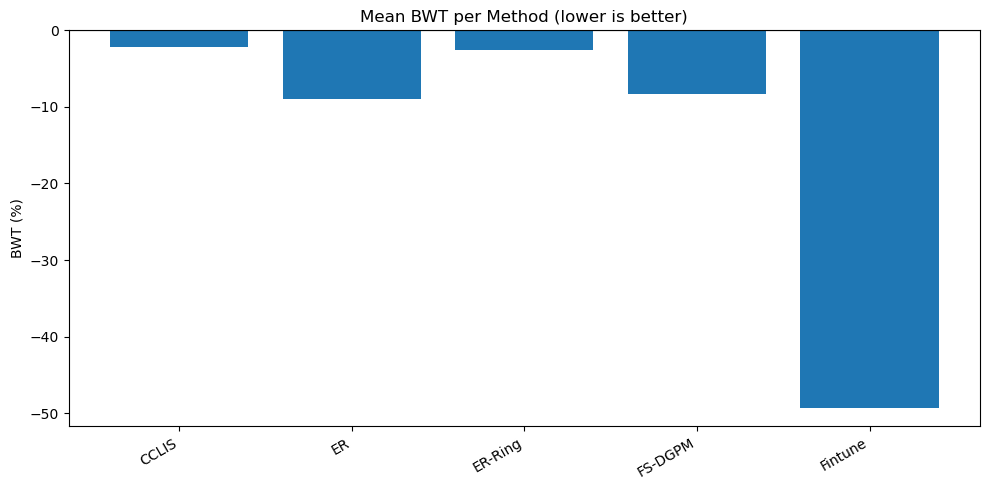

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

######################################################################
# 1. 事前準備  ―― ここは以前と同じ：手法 → 複数 seed の log ファイル
######################################################################
method_log_files = {
    'Fintune': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/fintune_er_reservoir0_cifar10_seed0_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/fintune_er_reservoir0_cifar10_seed1_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/fintune_er_reservoir0_cifar10_seed2_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/fintune_er_reservoir0_cifar10_seed3_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/fintune_er_reservoir0_cifar10_seed4_date2025_04_19/exp_log/experiment.log",
    ],
    'ER': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_cifar10_seed0_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_cifar10_seed1_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_cifar10_seed2_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_cifar10_seed3_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_cifar10_seed4_date2025_04_19/exp_log/experiment.log",
    ],
    'ER-Ring': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar10_seed0_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar10_seed1_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar10_seed2_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar10_seed3_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar10_seed4_date2025_04_19/exp_log/experiment.log",
    ],
    'FS-DGPM': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar10_seed0_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar10_seed1_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar10_seed2_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar10_seed3_date2025_04_19/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar10_seed4_date2025_04_19/exp_log/experiment.log",
    ],
    # 'GPM': [
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring0_cifar10_seed0_date2025_04_14/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring0_cifar10_seed1_date2025_04_14/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring0_cifar10_seed2_date2025_04_14/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring0_cifar10_seed3_date2025_04_14/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring0_cifar10_seed4_date2025_04_14/exp_log/experiment.log",
    # ],
    # 'GPM-ER': [
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring2000_cifar10_seed0_date2025_04_14/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring2000_cifar10_seed1_date2025_04_14/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring2000_cifar10_seed2_date2025_04_14/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring2000_cifar10_seed3_date2025_04_14/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/gpm/gpm_gpm_ring2000_cifar10_seed4_date2025_04_14/exp_log/experiment.log",
    # ],
    # 'Co2L': [
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar10_seed0_date2025_04_12/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar10_seed1_date2025_04_12/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar10_seed2_date2025_04_12/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar10_seed3_date2025_04_12/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar10_seed4_date2025_04_12/exp_log/experiment.log",
    # ],
    'CCLIS': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar10_seed0_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar10_seed1_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar10_seed2_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar10_seed3_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar10_seed4_date2025_04_20/exp_log/experiment.log",
    ],
}
N_TASKS = 5          # task0 〜 task9

######################################################################
# 2. ユーティリティ
######################################################################
task_header_pat   = re.compile(r'Start Training current task (\d+)')
epoch_line_pat    = re.compile(r'task\s+(\d+)\s+Epoch\s+(\d+):.*?(task0 acc=.*)')
acc_extract_pat   = re.compile(r'task(\d+)\s+acc=([\d.]+)')

def parse_log_return_matrix(path: str, max_tasks: int = 10):
    """1 本の log から R 行列(タスク × タスク) を返す"""
    R_rows          = []          # 各タスク終了時の task0..taskN accuracy
    current_task    = None
    last_acc_record = [np.nan]*max_tasks

    with open(path, 'r') as f:
        for line in f:
            # タスク開始行
            m_start = task_header_pat.search(line)
            if m_start:
                # 直前タスクの最終エポック行があれば保存
                if current_task is not None:
                    R_rows.append(last_acc_record.copy())
                current_task    = int(m_start.group(1))
                last_acc_record = [np.nan]*max_tasks
                continue

            # エポック行：常に last_acc_record を更新
            m_epoch = epoch_line_pat.search(line)
            if m_epoch:
                acc_info = m_epoch.group(3)      # "task0 acc=.., task1 acc=.., ..."
                for t, a in acc_extract_pat.findall(acc_info):
                    t, a = int(t), float(a)
                    if t < max_tasks:
                        last_acc_record[t] = a

    # ファイルの最後は忘れずに push
    if current_task is not None:
        R_rows.append(last_acc_record.copy())

    # 不完全タスク列を切り詰める
    R = np.array(R_rows, dtype=float)
    # 列・行とも “全部 nan の列/行” を削除
    valid_cols = ~np.isnan(R).all(axis=0)
    valid_rows = ~np.isnan(R).all(axis=1)
    return R[valid_rows][:, valid_cols]

def bwt_from_R(R: np.ndarray) -> float:
    """
    R[i, j] … タスク i 学習直後にタスク j をテストした精度
    BWT = 平均_i<last ( R[last, i] - R[i, i] )
    """
    T = R.shape[0]
    if T < 2:
        return np.nan       # 1タスクだけの場合は定義されない
    diag          = np.diag(R)
    last_row_prev = R[-1, :-1]
    return np.nanmean(last_row_prev - diag[:-1])

######################################################################
# 3. メインループ：各手法 × seed で R 行列 → BWT → DataFrame
######################################################################
records = []
for method, paths in method_log_files.items():
    for seed_idx, p in enumerate(paths):
        file_path = Path(p).expanduser()
        if not file_path.exists():
            print(f"⚠️  File not found: {file_path}")
            continue

        R = parse_log_return_matrix(file_path)
        print("method: ", method)
        bwt_val = bwt_from_R(R)
        records.append(
            {'Method': method,
             'Seed':   seed_idx,
             'Tasks':  R.shape[0],
             'BWT (%)': np.round(bwt_val, 3)}
        )

# DataFrame にまとめ，手法ごとの平均も併せて表示
df = pd.DataFrame(records)
mean_df = df.groupby('Method', as_index=False)['BWT (%)'].mean().rename(
            columns={'BWT (%)': 'Mean BWT (%)'})
display_df = df.merge(mean_df, on='Method')

print("\n=====  BWT (Backward Transfer)  =====")
print(display_df.to_string(index=False))

######################################################################
# 4. （任意）BWT を棒グラフで可視化
######################################################################
plt.figure(figsize=(10, 5))
plt.title('Mean BWT per Method (lower is better)')
plt.bar(mean_df['Method'], mean_df['Mean BWT (%)'])
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel('BWT (%)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


## CIFAR100

In [7]:
import re
import pandas as pd
from pathlib import Path

# ---------- ユーザ設定 ---------------------------------
method_log_files = {        # ここはご提示の dict をそのまま貼ってください
    'Fintune': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir0_cifar100_seed0_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir0_cifar100_seed1_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir0_cifar100_seed2_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir0_cifar100_seed3_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir0_cifar100_seed4_date2025_04_16/exp_log/experiment.log",
    ],
    'ER': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir2000_cifar100_seed0_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir2000_cifar100_seed1_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir2000_cifar100_seed2_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir2000_cifar100_seed3_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir2000_cifar100_seed4_date2025_04_16/exp_log/experiment.log",
    ],
    'ER-Ring': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar100_seed0_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar100_seed1_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar100_seed2_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar100_seed3_date2025_04_16/exp_log/experiment.log",
        # "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar100_seed4_date2025_04_16/exp_log/experiment.log",
    ],
    'FS-DGPM': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/practice_fs-dgpm_ring2000_cifar100_seed0_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/practice_fs-dgpm_ring2000_cifar100_seed1_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/practice_fs-dgpm_ring2000_cifar100_seed2_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/practice_fs-dgpm_ring2000_cifar100_seed3_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/practice_fs-dgpm_ring2000_cifar100_seed4_date2025_04_16/exp_log/experiment.log",
    ],
    'FS-DGPM w/o-fc': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar100_seed0_date2025_04_17/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar100_seed1_date2025_04_17/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar100_seed2_date2025_04_17/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar100_seed3_date2025_04_17/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar100_seed4_date2025_04_17/exp_log/experiment.log",
    ],
    'Co2L': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar100_seed0_date2025_04_18/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar100_seed1_date2025_04_18/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar100_seed2_date2025_04_18/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar100_seed3_date2025_04_18/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar100_seed4_date2025_04_18/exp_log/experiment.log",
    ],
    'CCLIS': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar100_seed0_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar100_seed1_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar100_seed2_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar100_seed3_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar100_seed4_date2025_04_20/exp_log/experiment.log",
    ],
}
N_TASKS = 10           # task0 ～ task{N_TASKS-1}
# ------------------------------------------------------

# 正規表現
re_start = re.compile(r"Start Training current task (\d+)")       # タスク開始
re_epoch = re.compile(r"Epoch (\d+):")                            # エポック番号
re_acc   = re.compile(r"task(\d+)\s+acc=([0-9]+\.[0-9]+)")        # taskX acc=…

def parse_last_epoch_acc(fp: Path, n_tasks: int = N_TASKS) -> pd.DataFrame:
    """
    1 つの experiment.log から
      current_task (行) × task0 … task{n_tasks-1} (列)
    の DataFrame を返す。値は「各 current_task の最終エポック行の精度」。
    """
    current_task = None
    last_row     = {}            # タスクごとの最後の行を随時更新
    with fp.open(encoding="utf-8") as f:
        for line in f:
            m_start = re_start.search(line)
            if m_start:
                current_task = int(m_start.group(1))
                continue

            # エポック行かつ acc= を含む行のみ対象
            if current_task is None or " acc=" not in line or "Epoch" not in line:
                continue

            # 各タスク精度を抽出
            acc_dict = {f"task{m.group(1)}": float(m.group(2))
                        for m in re_acc.finditer(line)}
            # 列が欠けている場合は NaN
            for t in range(n_tasks):
                acc_dict.setdefault(f"task{t}", float('nan'))

            # 更新（後ろの行ほど新しい → 最後に残る）
            last_row[current_task] = acc_dict

    # DataFrame 化
    df = (pd.DataFrame.from_dict(last_row, orient="index")
            .sort_index()
            .rename_axis("current_task")
            .reset_index())
    return df

# ------------------ 集計と表示 -------------------------
pd.set_option("display.max_columns", None)

for method, files in method_log_files.items():
    per_seed_tables = []
    for seed_idx, fp in enumerate(files):
        fp = Path(fp)
        if not fp.exists():
            print(f"[warn] {fp} が見つかりません")
            continue
        df_seed = parse_last_epoch_acc(fp)
        df_seed.insert(0, "seed", seed_idx)
        per_seed_tables.append(df_seed)

    if not per_seed_tables:
        print(f"[info] {method}: ログなし")
        continue

    # ========= ① 全シード分を縦に結合してそのまま表示 =========
    big_df = pd.concat(per_seed_tables, ignore_index=True)
    print(f"\n=== {method}: 学習終了時 (seed 別) ===")
    # print(big_df.head())        # head → 全部見たい場合は .to_string()
    print(big_df.to_string())

    # ========= ② シード平均が欲しい場合はここを使用 =========
    mean_df = (big_df
                 .groupby("current_task")
                 .mean(numeric_only=True)
                 .reset_index())
    print(f"\n--- {method}: シード平均 ---")
    print(mean_df.to_string(index=False))

    # 必要なら CSV 保存
    # mean_df.to_csv(f"{method}_final_task_acc.csv", index=False)
    



=== Fintune: 学習終了時 (seed 別) ===
    seed  current_task  task0  task1  task2  task3  task4  task5  task6  task7  task8  task9
0      0             0   82.0    9.9   13.3    7.7   10.9    6.8   13.7   11.0   12.0    7.1
1      0             1   53.1   78.1   14.9    9.2   10.4   11.0   15.7    8.2   10.6    7.8
2      0             2   52.0   60.6   84.5    6.2   10.5   10.1   12.5    7.0   18.1    6.0
3      0             3   39.6   53.2   55.4   85.4   12.7    5.7   11.7    9.9   12.8    7.8
4      0             4   34.9   47.5   56.5   58.3   85.5    7.0   14.2    6.6   10.8    8.7
5      0             5   29.6   28.4   35.5   49.9   59.5   83.6   13.8    9.6   10.7    8.5
6      0             6   29.4   24.3   26.8   30.9   40.4   56.8   84.5    9.2    9.4    7.4
7      0             7   22.1   22.5   30.1   26.9   32.2   44.6   62.3   82.9    6.4    7.2
8      0             8   25.4   26.1   29.8   26.3   35.0   35.4   39.8   51.3   88.2    8.5
9      0             9   14.3   16.7 

In [8]:
import re
import pandas as pd
from pathlib import Path

# --------------------- ユーザ設定 --------------------------
method_log_files = {        # ここはご提示の dict をそのまま貼ってください
    'Fintune': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir0_cifar100_seed0_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir0_cifar100_seed1_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir0_cifar100_seed2_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir0_cifar100_seed3_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir0_cifar100_seed4_date2025_04_16/exp_log/experiment.log",
    ],
    'ER': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir2000_cifar100_seed0_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir2000_cifar100_seed1_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir2000_cifar100_seed2_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir2000_cifar100_seed3_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir2000_cifar100_seed4_date2025_04_16/exp_log/experiment.log",
    ],
    'ER-Ring': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar100_seed0_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar100_seed1_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar100_seed2_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar100_seed3_date2025_04_16/exp_log/experiment.log",
        # "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar100_seed4_date2025_04_16/exp_log/experiment.log",
    ],
    'FS-DGPM': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/practice_fs-dgpm_ring2000_cifar100_seed0_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/practice_fs-dgpm_ring2000_cifar100_seed1_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/practice_fs-dgpm_ring2000_cifar100_seed2_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/practice_fs-dgpm_ring2000_cifar100_seed3_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/practice_fs-dgpm_ring2000_cifar100_seed4_date2025_04_16/exp_log/experiment.log",
    ],
    'FS-DGPM w/o-fc': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar100_seed0_date2025_04_17/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar100_seed1_date2025_04_17/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar100_seed2_date2025_04_17/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar100_seed3_date2025_04_17/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar100_seed4_date2025_04_17/exp_log/experiment.log",
    ],
    'Co2L': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar100_seed0_date2025_04_18/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar100_seed1_date2025_04_18/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar100_seed2_date2025_04_18/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar100_seed3_date2025_04_18/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar100_seed4_date2025_04_18/exp_log/experiment.log",
    ],
    'CCLIS': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar100_seed0_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar100_seed1_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar100_seed2_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar100_seed3_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar100_seed4_date2025_04_20/exp_log/experiment.log",
    ],
}
N_TASKS = 10          # task0 〜 task9
# ----------------------------------------------------------

re_start = re.compile(r"Start Training current task (\d+)")
re_acc   = re.compile(r"task(\d+)\s+acc=([0-9]+\.[0-9]+)")

def parse_last_epoch_acc(fp: Path, n_tasks=N_TASKS) -> pd.DataFrame:
    current_task = None
    last_row = {}
    with fp.open(encoding="utf-8") as f:
        for line in f:
            m_start = re_start.search(line)
            if m_start:
                current_task = int(m_start.group(1))
                continue
            if current_task is None or " acc=" not in line or "Epoch" not in line:
                continue

            accs = {f"task{m.group(1)}": float(m.group(2))
                    for m in re_acc.finditer(line)}
            for t in range(n_tasks):
                accs.setdefault(f"task{t}", float('nan'))
            last_row[current_task] = accs

    return (pd.DataFrame.from_dict(last_row, orient="index")
              .sort_index().rename_axis("current_task")
              .reset_index())

pd.set_option("display.max_columns", None)

for method, files in method_log_files.items():
    seed_tables = []
    for seed, path in enumerate(files):
        fp = Path(path)
        if not fp.exists():
            print(f"[warn] {fp} not found"); continue
        df_seed = parse_last_epoch_acc(fp)
        df_seed.insert(0, "seed", seed)
        seed_tables.append(df_seed)

    if not seed_tables:
        continue

    big_df = pd.concat(seed_tables, ignore_index=True)

    # ---- ① current_task == 9 の行を取り出し、タスク平均を計算 ------------
    task_cols = [f"task{i}" for i in range(N_TASKS)]
    ct9 = big_df[big_df["current_task"] == 9].copy()
    ct9["avg_all_tasks"] = ct9[task_cols].mean(axis=1)

    # ---- ② シードごとの平均精度 -----------------
    print(f"\n[{method}]  current_task 9 — seed 別平均精度")
    print(ct9[["seed", "avg_all_tasks"]].to_string(index=False))

    # ---- ③ シード間でさらに平均した 1 本の値 --------
    overall = ct9["avg_all_tasks"].mean()
    print(f"[{method}]  current_task 9 — 全シード平均: {overall:.2f}%")



[Fintune]  current_task 9 — seed 別平均精度
 seed  avg_all_tasks
    0          36.91
    1          37.80
    2          34.65
    3          37.47
    4          40.12
[Fintune]  current_task 9 — 全シード平均: 37.39%

[ER]  current_task 9 — seed 別平均精度
 seed  avg_all_tasks
    0          49.75
    1          52.11
    2          52.11
    3          47.40
    4          50.84
[ER]  current_task 9 — 全シード平均: 50.44%

[ER-Ring]  current_task 9 — seed 別平均精度
 seed  avg_all_tasks
    0          70.63
    1          69.41
    2          70.97
    3          70.31
[ER-Ring]  current_task 9 — 全シード平均: 70.33%

[FS-DGPM]  current_task 9 — seed 別平均精度
 seed  avg_all_tasks
    1          70.73
    2          70.65
    3          71.40
    4          70.31
[FS-DGPM]  current_task 9 — 全シード平均: 70.77%

[FS-DGPM w/o-fc]  current_task 9 — seed 別平均精度
 seed  avg_all_tasks
    0          71.42
    1          72.07
    2          71.16
    3          70.96
    4          70.42
[FS-DGPM w/o-fc]  current_task 9 — 全シード平均: 


=====  BWT (Backward Transfer)  =====
         Method  Seed  Tasks  BWT (%)  Mean BWT (%)
        Fintune     0     10  -52.767      -51.1934
        Fintune     1     10  -50.989      -51.1934
        Fintune     2     10  -54.011      -51.1934
        Fintune     3     10  -50.900      -51.1934
        Fintune     4     10  -47.300      -51.1934
             ER     0     10  -39.411      -37.6244
             ER     1     10  -34.733      -37.6244
             ER     2     10  -35.867      -37.6244
             ER     3     10  -41.322      -37.6244
             ER     4     10  -36.789      -37.6244
        ER-Ring     0     10  -14.167      -14.3085
        ER-Ring     1     10  -14.189      -14.3085
        ER-Ring     2     10  -12.800      -14.3085
        ER-Ring     3     10  -16.078      -14.3085
        FS-DGPM     0      0      NaN      -11.0805
        FS-DGPM     1     10  -11.089      -11.0805
        FS-DGPM     2     10  -10.989      -11.0805
        FS-DGPM     3    

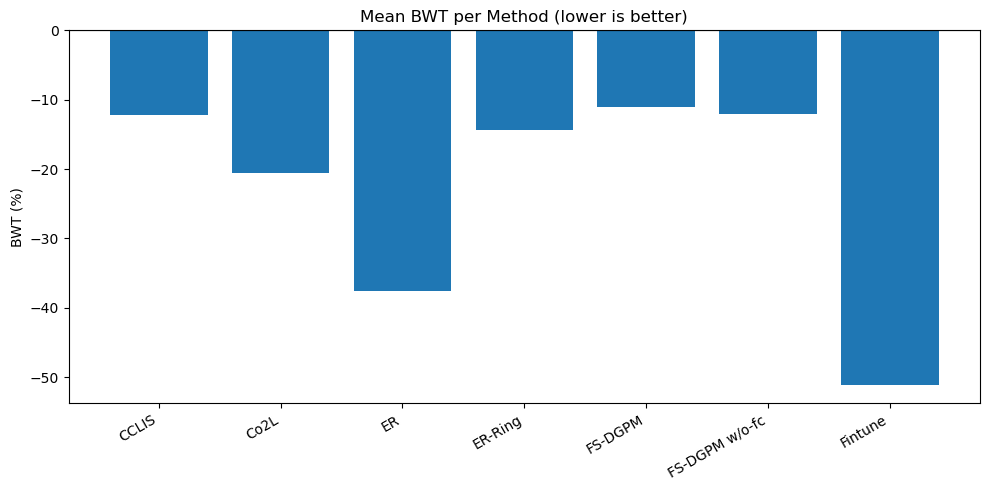

In [9]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

######################################################################
# 1. 事前準備  ―― ここは以前と同じ：手法 → 複数 seed の log ファイル
######################################################################
method_log_files = {        # ここはご提示の dict をそのまま貼ってください
    'Fintune': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir0_cifar100_seed0_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir0_cifar100_seed1_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir0_cifar100_seed2_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir0_cifar100_seed3_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir0_cifar100_seed4_date2025_04_16/exp_log/experiment.log",
    ],
    'ER': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir2000_cifar100_seed0_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir2000_cifar100_seed1_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir2000_cifar100_seed2_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir2000_cifar100_seed3_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_reservoir2000_cifar100_seed4_date2025_04_16/exp_log/experiment.log",
    ],
    'ER-Ring': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar100_seed0_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar100_seed1_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar100_seed2_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar100_seed3_date2025_04_16/exp_log/experiment.log",
        # "/home/kouyou/ContinualLearning/survey/CIL/logs/er/erring_er_ring2000_cifar100_seed4_date2025_04_16/exp_log/experiment.log",
    ],
    'FS-DGPM': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/practice_fs-dgpm_ring2000_cifar100_seed0_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/practice_fs-dgpm_ring2000_cifar100_seed1_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/practice_fs-dgpm_ring2000_cifar100_seed2_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/practice_fs-dgpm_ring2000_cifar100_seed3_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/practice_fs-dgpm_ring2000_cifar100_seed4_date2025_04_16/exp_log/experiment.log",
    ],
    'FS-DGPM w/o-fc': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar100_seed0_date2025_04_17/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar100_seed1_date2025_04_17/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar100_seed2_date2025_04_17/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar100_seed3_date2025_04_17/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/fs-dgpm/fs-dgpm_fs-dgpm_ring2000_cifar100_seed4_date2025_04_17/exp_log/experiment.log",
    ],
    'Co2L': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar100_seed0_date2025_04_18/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar100_seed1_date2025_04_18/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar100_seed2_date2025_04_18/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar100_seed3_date2025_04_18/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_cifar100_seed4_date2025_04_18/exp_log/experiment.log",
    ],
    'CCLIS': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar100_seed0_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar100_seed1_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar100_seed2_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar100_seed3_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_cifar100_seed4_date2025_04_20/exp_log/experiment.log",
    ],
}

######################################################################
# 2. ユーティリティ
######################################################################
task_header_pat   = re.compile(r'Start Training current task (\d+)')
epoch_line_pat    = re.compile(r'task\s+(\d+)\s+Epoch\s+(\d+):.*?(task0 acc=.*)')
acc_extract_pat   = re.compile(r'task(\d+)\s+acc=([\d.]+)')

def parse_log_return_matrix(path: str, max_tasks: int = 10):
    """1 本の log から R 行列(タスク × タスク) を返す"""
    R_rows          = []          # 各タスク終了時の task0..taskN accuracy
    current_task    = None
    last_acc_record = [np.nan]*max_tasks

    with open(path, 'r') as f:
        for line in f:
            # タスク開始行
            m_start = task_header_pat.search(line)
            if m_start:
                # 直前タスクの最終エポック行があれば保存
                if current_task is not None:
                    R_rows.append(last_acc_record.copy())
                current_task    = int(m_start.group(1))
                last_acc_record = [np.nan]*max_tasks
                continue

            # エポック行：常に last_acc_record を更新
            m_epoch = epoch_line_pat.search(line)
            if m_epoch:
                acc_info = m_epoch.group(3)      # "task0 acc=.., task1 acc=.., ..."
                for t, a in acc_extract_pat.findall(acc_info):
                    t, a = int(t), float(a)
                    if t < max_tasks:
                        last_acc_record[t] = a

    # ファイルの最後は忘れずに push
    if current_task is not None:
        R_rows.append(last_acc_record.copy())

    # 不完全タスク列を切り詰める
    R = np.array(R_rows, dtype=float)
    # 列・行とも “全部 nan の列/行” を削除
    valid_cols = ~np.isnan(R).all(axis=0)
    valid_rows = ~np.isnan(R).all(axis=1)
    return R[valid_rows][:, valid_cols]

def bwt_from_R(R: np.ndarray) -> float:
    """
    R[i, j] … タスク i 学習直後にタスク j をテストした精度
    BWT = 平均_i<last ( R[last, i] - R[i, i] )
    """
    T = R.shape[0]
    if T < 2:
        return np.nan       # 1タスクだけの場合は定義されない
    diag          = np.diag(R)
    last_row_prev = R[-1, :-1]
    return np.nanmean(last_row_prev - diag[:-1])

######################################################################
# 3. メインループ：各手法 × seed で R 行列 → BWT → DataFrame
######################################################################
records = []
for method, paths in method_log_files.items():
    for seed_idx, p in enumerate(paths):
        file_path = Path(p).expanduser()
        if not file_path.exists():
            print(f"⚠️  File not found: {file_path}")
            continue

        R = parse_log_return_matrix(file_path)
        bwt_val = bwt_from_R(R)
        records.append(
            {'Method': method,
             'Seed':   seed_idx,
             'Tasks':  R.shape[0],
             'BWT (%)': np.round(bwt_val, 3)}
        )

# DataFrame にまとめ，手法ごとの平均も併せて表示
df = pd.DataFrame(records)
mean_df = df.groupby('Method', as_index=False)['BWT (%)'].mean().rename(
            columns={'BWT (%)': 'Mean BWT (%)'})
display_df = df.merge(mean_df, on='Method')

print("\n=====  BWT (Backward Transfer)  =====")
print(display_df.to_string(index=False))

######################################################################
# 4. （任意）BWT を棒グラフで可視化
######################################################################
plt.figure(figsize=(10, 5))
plt.title('Mean BWT per Method (lower is better)')
plt.bar(mean_df['Method'], mean_df['Mean BWT (%)'])
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel('BWT (%)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


## tiny-imagenet

In [15]:
import re
import pandas as pd
from pathlib import Path

# ---------- ユーザ設定 ---------------------------------
method_log_files = {        # ここはご提示の dict をそのまま貼ってください
    # 'Fintune': [
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed0_date2025_04_20/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed1_date2025_04_20/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed2_date2025_04_20/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed3_date2025_04_20/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed4_date2025_04_20/exp_log/experiment.log",
    # ],
    'ER': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed0_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed1_date2025_04_20/exp_log/experiment.log",
        # "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed2_date2025_04_20/exp_log/experiment.log",
        # "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed3_date2025_04_20/exp_log/experiment.log",
        # "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed4_date2025_04_20/exp_log/experiment.log",
    ],
    'Co2L': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_tiny-imagenet_seed0_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_tiny-imagenet_seed1_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_tiny-imagenet_seed2_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_tiny-imagenet_seed3_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_tiny-imagenet_seed4_date2025_04_16/exp_log/experiment.log",
    ],
    # 'LUCIR': [
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/lucir/lucir_lucir_herding2000_tiny-imagenet_seed0_date2025_04_18/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/lucir/lucir_lucir_herding2000_tiny-imagenet_seed1_date2025_04_18/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/lucir/lucir_lucir_herding2000_tiny-imagenet_seed2_date2025_04_18/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/lucir/lucir_lucir_herding2000_tiny-imagenet_seed3_date2025_04_18/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/lucir/lucir_lucir_herding2000_tiny-imagenet_seed4_date2025_04_18/exp_log/experiment.log",
    # ],
    'CCLIS': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_tiny-imagenet_seed0_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_tiny-imagenet_seed1_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_tiny-imagenet_seed2_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_tiny-imagenet_seed3_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_tiny-imagenet_seed4_date2025_04_20/exp_log/experiment.log",
    ],
}
N_TASKS = 10           # task0 ～ task{N_TASKS-1}
# ------------------------------------------------------

# 正規表現
re_start = re.compile(r"Start Training current task (\d+)")       # タスク開始
re_epoch = re.compile(r"Epoch (\d+):")                            # エポック番号
re_acc   = re.compile(r"task(\d+)\s+acc=([0-9]+\.[0-9]+)")        # taskX acc=…

def parse_last_epoch_acc(fp: Path, n_tasks: int = N_TASKS) -> pd.DataFrame:
    """
    1 つの experiment.log から
      current_task (行) × task0 … task{n_tasks-1} (列)
    の DataFrame を返す。値は「各 current_task の最終エポック行の精度」。
    """
    current_task = None
    last_row     = {}            # タスクごとの最後の行を随時更新
    with fp.open(encoding="utf-8") as f:
        for line in f:
            m_start = re_start.search(line)
            if m_start:
                current_task = int(m_start.group(1))
                continue

            # エポック行かつ acc= を含む行のみ対象
            if current_task is None or " acc=" not in line or "Epoch" not in line:
                continue

            # 各タスク精度を抽出
            acc_dict = {f"task{m.group(1)}": float(m.group(2))
                        for m in re_acc.finditer(line)}
            # 列が欠けている場合は NaN
            for t in range(n_tasks):
                acc_dict.setdefault(f"task{t}", float('nan'))

            # 更新（後ろの行ほど新しい → 最後に残る）
            last_row[current_task] = acc_dict

    # DataFrame 化
    df = (pd.DataFrame.from_dict(last_row, orient="index")
            .sort_index()
            .rename_axis("current_task")
            .reset_index())
    return df

# ------------------ 集計と表示 -------------------------
pd.set_option("display.max_columns", None)

for method, files in method_log_files.items():
    per_seed_tables = []
    for seed_idx, fp in enumerate(files):
        fp = Path(fp)
        if not fp.exists():
            print(f"[warn] {fp} が見つかりません")
            continue
        df_seed = parse_last_epoch_acc(fp)
        df_seed.insert(0, "seed", seed_idx)
        per_seed_tables.append(df_seed)

    if not per_seed_tables:
        print(f"[info] {method}: ログなし")
        continue

    # ========= ① 全シード分を縦に結合してそのまま表示 =========
    big_df = pd.concat(per_seed_tables, ignore_index=True)
    print(f"\n=== {method}: 学習終了時 (seed 別) ===")
    # print(big_df.head())        # head → 全部見たい場合は .to_string()
    print(big_df.to_string())

    # ========= ② シード平均が欲しい場合はここを使用 =========
    mean_df = (big_df
                 .groupby("current_task")
                 .mean(numeric_only=True)
                 .reset_index())
    print(f"\n--- {method}: シード平均 ---")
    print(mean_df.to_string(index=False))

    # 必要なら CSV 保存
    mean_df.to_csv(f"{method}_final_task_acc.csv", index=False)



=== ER: 学習終了時 (seed 別) ===
    seed  current_task  task0  task1  task2  task3  task4  task5  task6  task7  task8  task9
0      0             0   75.6    4.9    4.7    5.4    5.1    4.3    3.5    3.8    3.7    5.0
1      0             1   70.4   68.7    3.8    5.3    5.0    6.3    4.8    5.2    4.0    5.1
2      0             2   56.0   57.5   71.6    4.7    4.9    5.7    5.1    5.5    4.5    4.1
3      0             3   35.7   47.6   67.7   76.5    6.7    6.9    3.0    4.7    4.6    6.0
4      0             4   16.4   30.5   57.6   68.7   71.2    5.8    4.9    4.5    5.2    6.4
5      0             5    7.7   18.1   37.9   57.9   63.4   70.8    4.0    3.2    5.0    5.9
6      0             6    5.0   10.2   14.8   33.0   59.6   66.2   74.2    4.7    3.6    5.5
7      0             7   10.4    9.1    6.6   16.4   36.7   52.4   66.6   69.3    5.3    5.4
8      0             8   11.3   11.7    5.1    5.0   13.9   34.6   58.2   62.5   67.3    4.2
9      0             9   12.4   11.9   10.

In [14]:
import re
import pandas as pd
from pathlib import Path

# --------------------- ユーザ設定 --------------------------
method_log_files = {        # ここはご提示の dict をそのまま貼ってください
    # 'Fintune': [
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed0_date2025_04_20/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed1_date2025_04_20/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed2_date2025_04_20/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed3_date2025_04_20/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed4_date2025_04_20/exp_log/experiment.log",
    # ],
    'ER': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed0_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed1_date2025_04_20/exp_log/experiment.log",
        # "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed2_date2025_04_20/exp_log/experiment.log",
        # "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed3_date2025_04_20/exp_log/experiment.log",
        # "/home/kouyou/ContinualLearning/survey/CIL/logs/er/er_er_reservoir2000_tiny-imagenet_seed4_date2025_04_20/exp_log/experiment.log",
    ],
    'Co2L': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_tiny-imagenet_seed0_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_tiny-imagenet_seed1_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_tiny-imagenet_seed2_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_tiny-imagenet_seed3_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_tiny-imagenet_seed4_date2025_04_16/exp_log/experiment.log",
    ],
    # 'LUCIR': [
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/lucir/lucir_lucir_herding2000_tiny-imagenet_seed0_date2025_04_18/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/lucir/lucir_lucir_herding2000_tiny-imagenet_seed1_date2025_04_18/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/lucir/lucir_lucir_herding2000_tiny-imagenet_seed2_date2025_04_18/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/lucir/lucir_lucir_herding2000_tiny-imagenet_seed3_date2025_04_18/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/lucir/lucir_lucir_herding2000_tiny-imagenet_seed4_date2025_04_18/exp_log/experiment.log",
    # ],
    'CCLIS': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_tiny-imagenet_seed0_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_tiny-imagenet_seed1_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_tiny-imagenet_seed2_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_tiny-imagenet_seed3_date2025_04_20/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/cclis/cclis_cclis_ring2000_tiny-imagenet_seed4_date2025_04_20/exp_log/experiment.log",
    ],
}
N_TASKS = 10           # task0 ～ task{N_TASKS-1}
# ----------------------------------------------------------

re_start = re.compile(r"Start Training current task (\d+)")
re_acc   = re.compile(r"task(\d+)\s+acc=([0-9]+\.[0-9]+)")

def parse_last_epoch_acc(fp: Path, n_tasks=N_TASKS) -> pd.DataFrame:
    current_task = None
    last_row = {}
    with fp.open(encoding="utf-8") as f:
        for line in f:
            m_start = re_start.search(line)
            if m_start:
                current_task = int(m_start.group(1))
                continue
            if current_task is None or " acc=" not in line or "Epoch" not in line:
                continue

            accs = {f"task{m.group(1)}": float(m.group(2))
                    for m in re_acc.finditer(line)}
            for t in range(n_tasks):
                accs.setdefault(f"task{t}", float('nan'))
            last_row[current_task] = accs

    return (pd.DataFrame.from_dict(last_row, orient="index")
              .sort_index().rename_axis("current_task")
              .reset_index())

pd.set_option("display.max_columns", None)

for method, files in method_log_files.items():
    seed_tables = []
    for seed, path in enumerate(files):
        fp = Path(path)
        if not fp.exists():
            print(f"[warn] {fp} not found"); continue
        df_seed = parse_last_epoch_acc(fp)
        df_seed.insert(0, "seed", seed)
        seed_tables.append(df_seed)

    if not seed_tables:
        continue

    big_df = pd.concat(seed_tables, ignore_index=True)

    # ---- ① current_task == 9 の行を取り出し、タスク平均を計算 ------------
    task_cols = [f"task{i}" for i in range(N_TASKS)]
    ct9 = big_df[big_df["current_task"] == 9].copy()
    ct9["avg_all_tasks"] = ct9[task_cols].mean(axis=1)

    # ---- ② シードごとの平均精度 -----------------
    print(f"\n[{method}]  current_task 9 — seed 別平均精度")
    print(ct9[["seed", "avg_all_tasks"]].to_string(index=False))

    # ---- ③ シード間でさらに平均した 1 本の値 --------
    overall = ct9["avg_all_tasks"].mean()
    print(f"[{method}]  current_task 9 — 全シード平均: {overall:.2f}%")



[ER]  current_task 9 — seed 別平均精度
 seed  avg_all_tasks
    0          28.96
    1          30.99
[ER]  current_task 9 — 全シード平均: 29.98%

[Co2L]  current_task 9 — seed 別平均精度
 seed  avg_all_tasks
    0          49.30
    1          49.40
    2          50.26
    3          48.09
    4          49.09
[Co2L]  current_task 9 — 全シード平均: 49.23%

[CCLIS]  current_task 9 — seed 別平均精度
 seed  avg_all_tasks
    0          56.26
    1          56.46
    2          57.22
    3          57.83
    4          57.97
[CCLIS]  current_task 9 — 全シード平均: 57.15%



=====  BWT (Backward Transfer)  =====
Method  Seed  Tasks  BWT (%)  Mean BWT (%)
  Co2L     0     10  -31.478      -31.5466
  Co2L     1     10  -31.189      -31.5466
  Co2L     2     10  -30.922      -31.5466
  Co2L     3     10  -32.411      -31.5466
  Co2L     4     10  -31.733      -31.5466


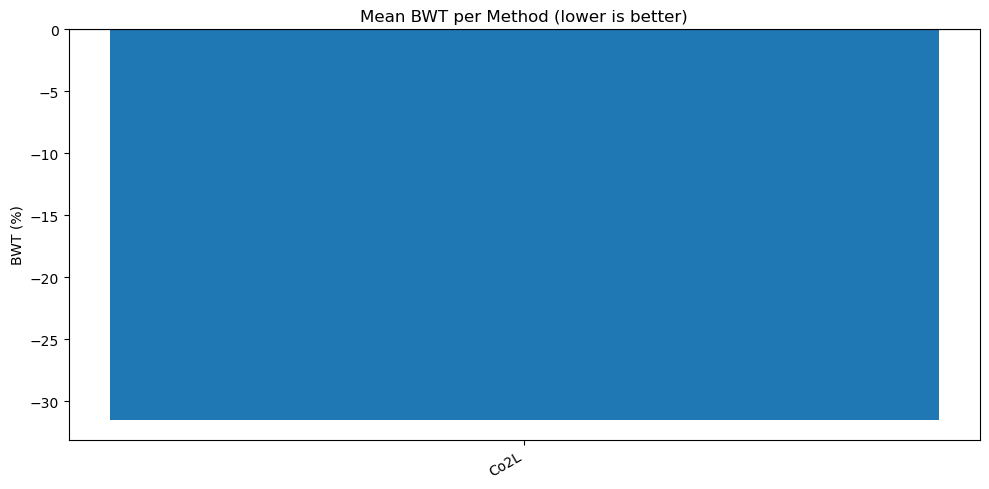

In [9]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

######################################################################
# 1. 事前準備  ―― ここは以前と同じ：手法 → 複数 seed の log ファイル
######################################################################
method_log_files = {        # ここはご提示の dict をそのまま貼ってください
    'Co2L': [
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_tiny-imagenet_seed0_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_tiny-imagenet_seed1_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_tiny-imagenet_seed2_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_tiny-imagenet_seed3_date2025_04_16/exp_log/experiment.log",
        "/home/kouyou/ContinualLearning/survey/CIL/logs/co2l/co2l_co2l_ring2000_tiny-imagenet_seed4_date2025_04_16/exp_log/experiment.log",
    ],
    # 'LUCIR': [
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/lucir/lucir_lucir_herding2000_tiny-imagenet_seed0_date2025_04_18/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/lucir/lucir_lucir_herding2000_tiny-imagenet_seed1_date2025_04_18/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/lucir/lucir_lucir_herding2000_tiny-imagenet_seed2_date2025_04_18/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/lucir/lucir_lucir_herding2000_tiny-imagenet_seed3_date2025_04_18/exp_log/experiment.log",
    #     "/home/kouyou/ContinualLearning/survey/CIL/logs/lucir/lucir_lucir_herding2000_tiny-imagenet_seed4_date2025_04_18/exp_log/experiment.log",
    # ],
}

######################################################################
# 2. ユーティリティ
######################################################################
task_header_pat   = re.compile(r'Start Training current task (\d+)')
epoch_line_pat    = re.compile(r'task\s+(\d+)\s+Epoch\s+(\d+):.*?(task0 acc=.*)')
acc_extract_pat   = re.compile(r'task(\d+)\s+acc=([\d.]+)')

def parse_log_return_matrix(path: str, max_tasks: int = 10):
    """1 本の log から R 行列(タスク × タスク) を返す"""
    R_rows          = []          # 各タスク終了時の task0..taskN accuracy
    current_task    = None
    last_acc_record = [np.nan]*max_tasks

    with open(path, 'r') as f:
        for line in f:
            # タスク開始行
            m_start = task_header_pat.search(line)
            if m_start:
                # 直前タスクの最終エポック行があれば保存
                if current_task is not None:
                    R_rows.append(last_acc_record.copy())
                current_task    = int(m_start.group(1))
                last_acc_record = [np.nan]*max_tasks
                continue

            # エポック行：常に last_acc_record を更新
            m_epoch = epoch_line_pat.search(line)
            if m_epoch:
                acc_info = m_epoch.group(3)      # "task0 acc=.., task1 acc=.., ..."
                for t, a in acc_extract_pat.findall(acc_info):
                    t, a = int(t), float(a)
                    if t < max_tasks:
                        last_acc_record[t] = a

    # ファイルの最後は忘れずに push
    if current_task is not None:
        R_rows.append(last_acc_record.copy())

    # 不完全タスク列を切り詰める
    R = np.array(R_rows, dtype=float)
    # 列・行とも “全部 nan の列/行” を削除
    valid_cols = ~np.isnan(R).all(axis=0)
    valid_rows = ~np.isnan(R).all(axis=1)
    return R[valid_rows][:, valid_cols]

def bwt_from_R(R: np.ndarray) -> float:
    """
    R[i, j] … タスク i 学習直後にタスク j をテストした精度
    BWT = 平均_i<last ( R[last, i] - R[i, i] )
    """
    T = R.shape[0]
    if T < 2:
        return np.nan       # 1タスクだけの場合は定義されない
    diag          = np.diag(R)
    last_row_prev = R[-1, :-1]
    return np.nanmean(last_row_prev - diag[:-1])

######################################################################
# 3. メインループ：各手法 × seed で R 行列 → BWT → DataFrame
######################################################################
records = []
for method, paths in method_log_files.items():
    for seed_idx, p in enumerate(paths):
        file_path = Path(p).expanduser()
        if not file_path.exists():
            print(f"⚠️  File not found: {file_path}")
            continue

        R = parse_log_return_matrix(file_path)
        bwt_val = bwt_from_R(R)
        records.append(
            {'Method': method,
             'Seed':   seed_idx,
             'Tasks':  R.shape[0],
             'BWT (%)': np.round(bwt_val, 3)}
        )

# DataFrame にまとめ，手法ごとの平均も併せて表示
df = pd.DataFrame(records)
mean_df = df.groupby('Method', as_index=False)['BWT (%)'].mean().rename(
            columns={'BWT (%)': 'Mean BWT (%)'})
display_df = df.merge(mean_df, on='Method')

print("\n=====  BWT (Backward Transfer)  =====")
print(display_df.to_string(index=False))

######################################################################
# 4. （任意）BWT を棒グラフで可視化
######################################################################
plt.figure(figsize=(10, 5))
plt.title('Mean BWT per Method (lower is better)')
plt.bar(mean_df['Method'], mean_df['Mean BWT (%)'])
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel('BWT (%)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()
